In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import healpy as hp
import rubin_sim.skybrightness as sb
from rubin_sim.utils import Site, hpid2RaDec, calcLmstLast

In [2]:
# we can specify the site with any object that has proper atttributes. Someone double check that these coords are right
# Note that lots of the code is assuming LSST location, so while we've set an observatory altitude, it's not actually 
# going to change the sky brightness values. As long as the observatories are similar enough, this should be OK.
paranal = Site(latitude=-24.627222, longitude=-70.404167, height=2635.)


sky_model = sb.SkyModel(observatory=paranal, mags=True)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/utils/Site.py:225: UserWarning: The following attributes of your Site were None:
temperature
pressure
humidity
lapseRate
If you want these to just default to LSST values,
instantiate your Site with name='LSST'
  warnings.warn(msg)


In [3]:
# Let's set up a healpix grid of RA,dec points
nside = 32
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
# Modified Julian Date. Set this to a time you would want to take flats
mjd = 58000.

In [4]:
# compute the sky model for a given time on our grid
sky_model.setRaDecMjd(ra, dec, mjd, degrees=True)

In [5]:
# return a dict of sky brightness mags/sq arcsec (LSST filters). You can set it to compute the full spectra
# and then define your own passbands, but hopefully this is good enough
mu = sky_model.returnMags()

/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the 

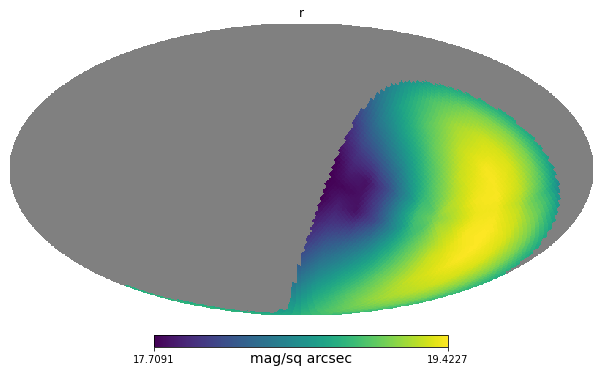

In [6]:
# Take a look at the r band
filtername = 'r'
hp.mollview(mu[filtername], unit='mag/sq arcsec', title=filtername)

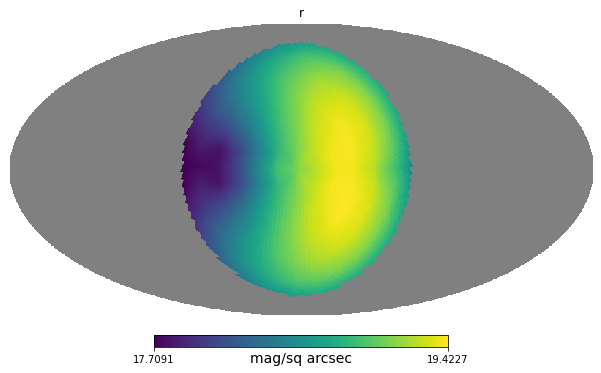

In [7]:
# hey, look at that, the moon is up. Note the model breaks down close (~25 degrees) to the moon.
# It can be nice to rotate to alt,az projection, zenith at the center
lmst,last = calcLmstLast(sky_model.mjd, sky_model.telescope.longitude)
hp.mollview(mu[filtername], unit='mag/sq arcsec', title=filtername,rot=(lmst*15,
                                                                        sky_model.telescope.latitude))

In [8]:
# we can also load up the stellar density maps and see what that looks like
from rubin_sim.maf.maps import TrilegalDensityMap

In [9]:
# define the grid we want
sp = {'ra': np.radians(ra), 'dec': np.radians(dec), 'nside': nside}
sdm = TrilegalDensityMap(filtername=filtername, ext=True)
# Add the map we wanted to the dict
sp = sdm.run(sp)
sp
# do a help(TrilegalDensityMap) to see what those new keys are. 

{'ra': array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]),
 'dec': array([ 1.54528012,  1.54528012,  1.54528012, ..., -1.54528012,
        -1.54528012, -1.54528012]),
 'nside': 32,
 'starLumFunc_r': array([[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [  125.10520078,   193.01945264,   284.76326654, ...,
         93234.35301397, 93234.35301397, 93234.35301397],
        [  157.27510956,   246.63596726,   332.42239065, ...,
         98257.62469493, 98257.62469493, 98257.62469493],
        [  128.67963509,   184.67910592,   270.46552931, ...,
         85533.83003625, 85533.83003625, 85533.83003625]]),
 'starMapBins_r': array([

<ipython-input-10-82918dfbf800>:3: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(np.log10(sp['starLumFunc_r'][:,i]), unit='log10(stars/sq deg)',
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/yoachim/anaconda3/envs/testenv/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  ne

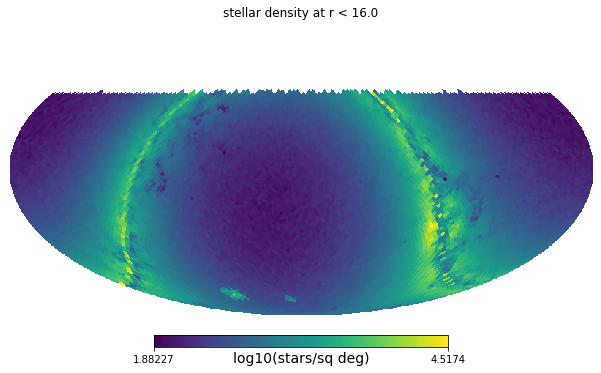

In [10]:
# Let's
i = 5
hp.mollview(np.log10(sp['starLumFunc_r'][:,i]), unit='log10(stars/sq deg)',
            title='stellar density at %s < %.1f' % (filtername, sp['starMapBins_r'][i]))


In [11]:
# ok, let's mask out where the stellar density is too high, setting some threshold by eye:
mask = np.where(np.log10(sp['starLumFunc_r'][:,i]) > 3.1)[0]
masked_mu = mu[filtername] + 0  # Easy way to copy a variable
masked_mu[mask] = np.nan

<ipython-input-11-b30b7cd68534>:2: RuntimeWarning: divide by zero encountered in log10
  mask = np.where(np.log10(sp['starLumFunc_r'][:,i]) > 3.1)[0]


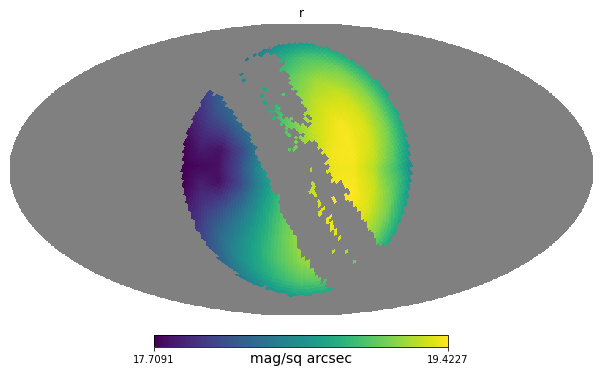

In [12]:
hp.mollview(masked_mu, unit='mag/sq arcsec', title=filtername,rot=(lmst*15,
                                                                        sky_model.telescope.latitude))

In [13]:
# and then you could add in some masks around very bright stars or something. 
# Here are the three relevant arrays for figuring out where one might like to point
print(masked_mu, ra, dec)

[        nan         nan         nan ... 18.79950412 18.85694836
 18.84458477] [ 45. 135. 225. ... 135. 225. 315.] [ 88.53802884  88.53802884  88.53802884 ... -88.53802884 -88.53802884
 -88.53802884]


In [14]:
# Note the sky model has all kinds of handy things computed and stored:
sky_model.getComputedVals()

{'ra': array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]),
 'dec': array([ 1.54528012,  1.54528012,  1.54528012, ..., -1.54528012,
        -1.54528012, -1.54528012]),
 'alts': array([-0.44684801, -0.44869083, -0.41263985, ...,  0.41082721,
         0.44684801,  0.44869083]),
 'azs': array([0.02099397, 6.26420127, 6.262518  , ..., 3.16025   , 3.16258663,
        3.12260862]),
 'airmass': array([-2.31414426, -2.30528244, -2.49358527, ...,  2.50395721,
         2.31414426,  2.30528244]),
 'solarFlux': 130.0,
 'moonPhase': 84.84605828059799,
 'moonAz': 1.5033324213945205,
 'moonAlt': 0.8301183351598008,
 'sunAlt': -0.36606051182288013,
 'sunAz': 4.684095978350288,
 'azRelSun': array([1.6200833 , 1.58010529, 1.57842202, ..., 4.75933933, 4.76167596,
        4.72169794]),
 'moonSunSep': 152.72290490507638,
 'azRelMoon': array([1.48233845, 1.52231646, 1.52399973, ..., 1.65691758, 1.65925421,
        1.61927619]),
 'eclipLon': array([1.52750552, 1.61456